# Network analysis in Python

Finding a shortest path using a specific street network is a common GIS problem
that has many practical applications. For example, navigation, one of those
‘every-day’ applications for which **routing** algorithms are used to find the
optimal route between two or more points.

Of course, the Python ecosystem has produced packages that can be used to
conduct network analyses, such as routing. The
[NetworkX](https://networkx.github.io/documentation/) package provides various
tools to analyse networks, and implements several different routing algorithms,
such as the
[Dijkstra’s](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html)
or the
[A\*](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html#module-networkx.algorithms.shortest_paths.astar)
algorithms. Both are commonly used to find shortest paths along transport networks.

To be able to conduct network analysis, it is, of course, necessary to have a
network that is used for the analyses. The
[OSMnx](https://osmnx.readthedocs.io/) package enables us to retrieve routable
networks from OpenStreetMap for various transport modes (walking, cycling and
driving). OSMnx also wraps some of NetworkX’s functionality in a convenient way
for using it on OpenStreetMap data.

In the following section, we will use OSMnx to find the shortest path between
two points based on cyclable roads. With only the tiniest modifications, we can
then repeat the analysis for the walkable street network.



## Obtain a routable network

To download OpenStreetMap data that represents the street network, we can use
it’s
[`graph_from_place()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_place)
function. As parameters, it expects a place name and, optionally, a network
type.

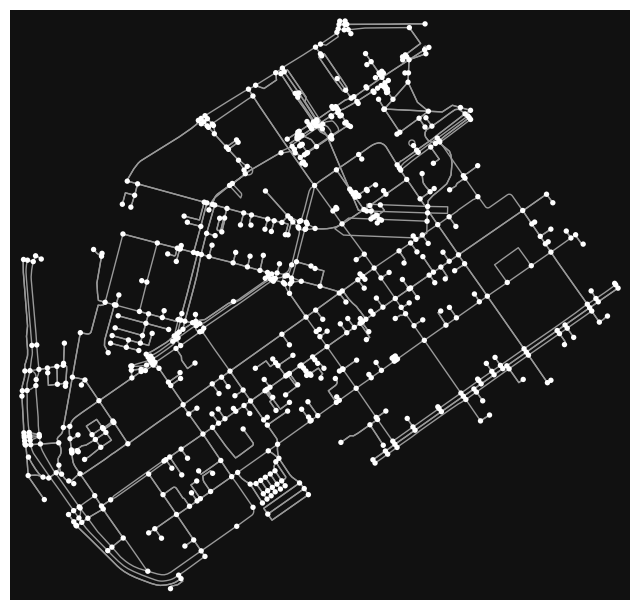

In [1]:
import osmnx

PLACE_NAME = "Kamppi, Helsinki, Finland"
graph = osmnx.graph_from_place(
    PLACE_NAME,
    network_type="bike"
)
figure, ax = osmnx.plot_graph(graph)

> **Pro tip!**  
> Sometimes the shortest path might go slightly outside the defined area of interest. To account for this, we can fetch the network for a bit larger area than the district of Kamppi, in case the shortest path is not completely inside its boundaries.


In [ ]:
# Get the area of interest polygon


# Re-project the polygon to a local projected CRS (so that the CRS unit is meters)


# Buffer by 200 meters


# Re-project the polygon back to WGS84 (required by OSMnx)


# Retrieve the network graph
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="bike"
)

fig, ax = osmnx.plot_graph(graph)

### Data overview

Now that we obtained a complete network graph for the travel mode we specified
(cycling), we can take a closer look at which attributes are assigned to the
nodes and edges of the network. It is probably easiest to first convert the
network into a geo-data frame on which we can then use the tools we learnt in
earlier lessons.

To convert a graph into a geo-data frame, we can use `osmnx.graph_to_gdfs()`
(see [previous section](retrieve-data-from-openstreetmap)). Here, we can make
use of the function’s parameters `nodes` and `edges` to select whether we want
only nodes, only edges, or both (the default):

In [ ]:
# Retrieve only edges from the graph
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

The resulting geo-data frame comprises of a long list of columns. Most of them
relate to [OpenStreetMap tags](https://wiki.openstreetmap.org/wiki/Tags), and
their names are rather self-explanatory. the columns `u` and `v` describe the
topological relationship within the network: they denote the start and end node
of each edge.

| Column                                                                 | Description                         | Data type         |
|------------------------------------------------------------------------|-------------------------------------|-------------------|
| [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)                | Bridge feature                      | boolean           |
| geometry                                                              | Geometry of the feature             | Shapely.geometry  |
| [highway](http://wiki.openstreetmap.org/wiki/Key:highway)              | Tag for roads (road type)           | str / list        |
| [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)                  | Number of lanes                     | int (or nan)      |
| [length](http://wiki.openstreetmap.org/wiki/Key:length)                | Length of feature (meters)          | float             |
| [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)            | Maximum legal speed limit           | int / list        |
| [name](http://wiki.openstreetmap.org/wiki/Key:name)                    | Name of the (street) element        | str (or nan)      |
| [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)                | One way road                        | boolean           |
| [osmid](http://wiki.openstreetmap.org/wiki/Node)                       | Unique ids for the element          | list              |
| [u](http://ow.ly/bV8n30h7Ufm)                                         | The start node of edge              | int               |
| [v](http://ow.ly/bV8n30h7Ufm)                                         | The end node of edge                | int               |


What types of streets does our network comprise of?

### Transform to projected reference system

The network data’s cartographic reference system (CRS) is WGS84 (EPSG:4326), a
geographic reference system. That means, distances are recorded and expressed
in degrees, areas in square-degrees. This is not convenient for network
analyses, such as finding a shortest path.

Again, OSMnx’s *graph* objects do not offer a method to transform their
geodata, but OSMnx comes with a separate function:
[`osmnx.project_graph()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph)
accepts an input graph and a CRS as parameters, and returns a new, transformed,
graph. If `crs` is omitted, the transformation defaults to the locally most
appropriate UTM zone.

In [ ]:
# Transform the graph to UTM
try:
    graph = osmnx.project_graph(graph) 
except:
    print("Already transformed")

# Extract reprojected nodes and edges
nodes, edges = osmnx.graph_to_gdfs(graph)

nodes.crs




### Analysing network properties

Now that we have prepared a routable network graph, we can turn to the more
analytical features of OSMnx, and extract information about the network.
To compute basic network characteristics, use
[`osmnx.basic_stats()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats):

In [ ]:
# Calculate network statistics
osmnx.basic_stats(graph)

This does not yet yield all interesting characteristics of our network, as
OSMnx does not automatically take the area covered by the network into
consideration. We can do that manually, by, first, delineating the [complex
hull](https://en.wikipedia.org/wiki/Convex_hull) of the network (of an ’unary’
union of all its features), and then, second, computing the area of this hull.

In [ ]:
convex_hull = edges.unary_union.convex_hull
convex_hull

In [ ]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

As we can see, now we have a lot of information about our street network that
can be used to understand its structure. We can for example see that the average
node density in our network is 729.5&nbsp;nodes/km and that
the total edge length of our network is more than
92&nbsp;kilometers.


> **Note: Centrality measures**  
> In earlier years, this course also discussed [degree centrality](https://en.wikipedia.org/wiki/Centrality). Computing network centrality has changed in OSMnx: going in-depth would be beyond the scope of this course. Please see the [OSMnx notebook](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/06-stats-indicators-centrality.ipynb) for an example.


---


## Shortest path analysis

Let’s now calculate the shortest path between two points using
[`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).



### Origin and destination points 

First we need to specify the source and target locations for our route. If you
are familiar with the Kamppi area, you can specify a custom placename as a
source location. Or, you can follow along and choose these points as the origin
and destination in the analysis:
- [`"Maria 01, Helsinki"`](https://nominatim.openstreetmap.org/ui/search.html?q=Maria+01):
  a startup hub in a former hospital area.
- [`"ruttopuisto"`](https://nominatim.openstreetmap.org/ui/search.html?q=ruttopuisto),
  a park. The park’s official name is ’Vanha kirkkopuisto’, but Nominatim
  is also able to geocode the nickname.

We could figure out the coordinates for these locations manually, and create
`shapely.geometry.Point`s based on the coordinates.  However, if we would have
more than just two points, that would quickly become a chore. Instead, we can
use OSMnx to geocode the locations.

Remember to transform the origin and destination points to the same reference
system as the network data.

In [ ]:
origin = (
    osmnx.geocode_to_gdf("Maria 01, Helsinki")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    osmnx.geocode_to_gdf("ruttopuisto")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

We now have `shapely.geometry.Point`s representing the origin and destination
locations for our network analysis. In a next step, we need find these points on
the routable network before the final routing.



### Nearest node

To route on the network, we first have to find a starting point and endpoint
that is part of the network. Use
`[osmnx.distance.nearest_nodes()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.nearest_nodes)
to return the nearest node’s ID:

In [ ]:
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)
destination_node_id

### Routing

Now we are ready for routing and to find the shortest path between the
origin and target locations. We will use
[`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).

The function accepts three mandatory parameters: a graph, an origin node id, and
a destination node id, and two optional parameters: `weight` can be set to
consider a different *cost impedance* than the length of the route, and `cpus`
controls parallel computation of many routes.

As a result we get a list of all the nodes that are along the shortest path. 

We could extract the locations of those nodes from the `nodes`
GeoDataFrame and create a LineString presentation of the points, but luckily,
OSMnx can do that for us and we can plot shortest path by using
`plot_graph_route()` function:

In [ ]:
# Plot the shortest path
fig, ax = osmnx.plot_graph_route(graph, route)

Nice! Now we have the shortest path between our origin and target locations.
Being able to analyze shortest paths between locations can be valuable
information for many applications.  Here, we only analyzed the shortest paths
based on distance but quite often it is more useful to find the optimal routes
between locations based on the travelled time. Here, for example we could
calculate the time that it takes to cross each road segment by dividing the
length of the road segment with the speed limit and calculate the optimal
routes by taking into account the speed limits as well that might alter the
result especially on longer trips than here.



## Saving shortest paths to disk

Quite often you need to save the route into a file for further analysis and
visualization purposes, or at least have it as a GeoDataFrame object in Python.
Hence, let's continue still a bit and see how we can turn the route into a
linestring and save the shortest path geometry and related attributes into a
geopackage file.

First we need to get the nodes that belong to the shortest path:

In [ ]:
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]
route_nodes

As we can see, now we have all the nodes that were part of the shortest path as a GeoDataFrame.

Now we can create a LineString out of the Point geometries of the nodes:

In [ ]:
import shapely.geometry

# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

Now we have the route as a LineString geometry. 

Let's make a GeoDataFrame out of it having some useful information about our
route such as a list of the osmids that are part of the route and the length
of the route.

In [ ]:
import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()

Now we have a GeoDataFrame that we can save to disk. Let's still confirm that
everything is ok by plotting our route on top of our street network and some
buildings, and plot also the origin and target points on top of our map.

Download buildings:

In [ ]:
buildings = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

Let's now plot the route and the street network elements to verify that
everything is as it should:

In [ ]:
import contextily
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

Great everything seems to be in order! As you can see, now we have a full
control of all the elements of our map and we can use all the aesthetic
properties that matplotlib provides to modify how our map will look like. Now
we are almost ready to save our data into disk.



## Prepare data for saving to file

The data contain certain data types (such as `list`) that should be converted
into character strings prior to saving the data to file (an alternative would be
to drop invalid columns).

In [ ]:
edges.head()

In [ ]:
# Columns with invalid values
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "tunnel",
    "access",
    "service",
    
]

#  convert selected columns to string format
edges[problematic_columns] = edges[problematic_columns].astype(str)

In [ ]:
route_geom["osm_nodes"] = route_geom["osm_nodes"].astype(str)

Now we can see that most of the attributes are of type `object` that quite
often (such as ours here) refers to a string type of data.

## Save the data:

In [ ]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [ ]:
# Save one layer after another
output_gpkg = DATA_DIRECTORY / "OSM_Kamppi.gpkg"

edges.to_file(output_gpkg, layer="streets")
route_geom.to_file(output_gpkg, layer="route")
nodes.to_file(output_gpkg, layer="nodes")
buildings[['geometry', 'name', 'addr:street']].to_file(output_gpkg, layer="buildings")

Great, now we have saved all the data that was used to produce the maps into a geopackage.



## Advanced reading

Here we learned how to solve a simple routing task between origin and
destination points. What about if we have hundreads or thousands of origins?
This is the case if you want to explore the travel distances to a spesific
location across the whole city, for example, when analyzing the accessibility
of jobs and services (like in the Travel Time Matrix dataset used in previous
sections). 

Check out pyrosm documentation on [working with
graphs](https://pyrosm.readthedocs.io/en/latest/graphs.html#working-with-graphs)
for more advanced examples of network analysis in python. For example,
[pandana](https://udst.github.io/pandana/) is a fast and efficient python
library for creating aggretated network analysis in no time across large
networks, and pyrosm can be used for preparing the input data for such
analysis.